In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.io.wavfile as wf

from glob import glob
from collections import deque
from zplane import *

#import audiofile

# 0. Plot functions

In [2]:
def simple_plot(samples, x_values= np.array([]), plt_title= "", x_label="", y_label="", display_plot=True, save_name=None, bars : list = []):
    _ = plt.figure()
    plt.title(plt_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if len(x_values) == 0:
        plt.plot(samples)
    else:
        plt.plot(x_values, samples)
    if bars != []:
        for bar in bars:
            # bar = 1
            plt.axvline(bar, color="gray", linestyle="--")
            pass
    if save_name != None:
        plt.savefig(save_name)
    if display_plot:
        plt.show()
    plt.close() 

In [3]:
def plot_create_sin(f, A, fs, N, bars : list = []):
    t, samples = create_sine_wave(f, A, fs, N)
    plot_sin(t, samples, bars)

def plot_sin(t, samples, bars : list = []):
    if type(t) == type(None):
        t = np.array([])
    simple_plot(samples, t, f"Sin wave", "Time (sample)" if len(t) == 0 else "Time (s)", "Amplitude (V)", display_plot=True, bars=bars)

def plot_sound_wave(data):
    simple_plot(data, plt_title=f"Sound Wave {file_name}", x_label="Time (sample)", y_label="Amplitude (V)")

def plot_filter(B_filter, A_filter, fs):
    w_a, h_a = signal.freqz(B_filter, A_filter, fs= fs)
    plt.figure()
    plt.xlabel("f (Hz)")
    plt.ylabel("Amplitude (dB)")
    plt.plot(w_a, 20 * np.log10(np.abs(h_a)))
    plt.grid(which="both", axis="both")
    plt.show()
    plt.close()


# 1. Offline System

## 1.1 Data generation and dataset

### 1.1.1 Sine wave function

In [4]:
def create_sine_wave(f, A, fs, N):
    sampling = np.arange(0, N/fs,1/fs)
    sin_samples =  np.sin(2 * np.pi * sampling * f)
    return sampling, A * sin_samples

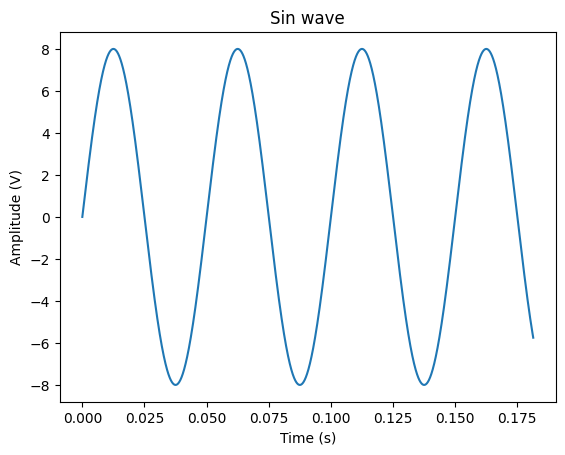

In [5]:
ws = 44.1 * 1000
N = 8000

f = 20
amplitude = 8


plot_create_sin(f, amplitude, ws, N)

### 1.1.2 Read Wavefile function

In [6]:
def read_wavefile(path):
    return wf.read(path)

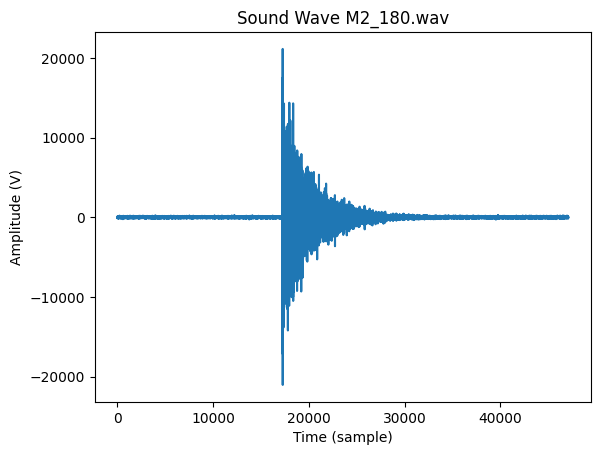

In [7]:
file_dir = "LocateClaps/"
file_name = "M2_180.wav"

t, data1 = read_wavefile(file_dir + file_name)

plot_sound_wave(data1)

Find all files ending in `.wav`, and save the results inside a folder

In [8]:
skip_saving = True
SavePlotFile = "SoundWavePlots/"
LocateClaps = "./LocateClaps"
files = glob(f"{LocateClaps}/*.wav")

if not skip_saving:
    for file in files:
        _, data1 = read_wavefile(file)
        file_name = file.removeprefix(LocateClaps + "/").removesuffix(".wav") # keep only the name

        simple_plot(data1, plt_title=f"Sound Wave {file_name}.wav", x_label="Time (s)", y_label="Amplitude (V)", 
                    display_plot=False, save_name=f"{SavePlotFile}/{file_name}")

## 1.2 Buffering

### 1.2.1 Create the `create_ringbuffer` function

See the following documentation : [Collections `deque`](https://docs.python.org/3/library/collections.html#collections.deque)

In [9]:
def create_ringbuffer(maxlen) -> deque:
    return deque(maxlen=maxlen)

def plot_buffer_content(buffer: deque, sample_added: int, recording_time: int):
    sample_text = "sample" if sample_added == 0 else "samples"

    simple_plot(buffer, plt_title=f"Buffer contents after adding {sample_added} {sample_text} (i.e. after {recording_time} s)", 
                x_label= "Stored sample",y_label="Amplitude (s)")


### 1.2.2 Display the buffers content after *recording* for **0.1 s** and **0.15 s**

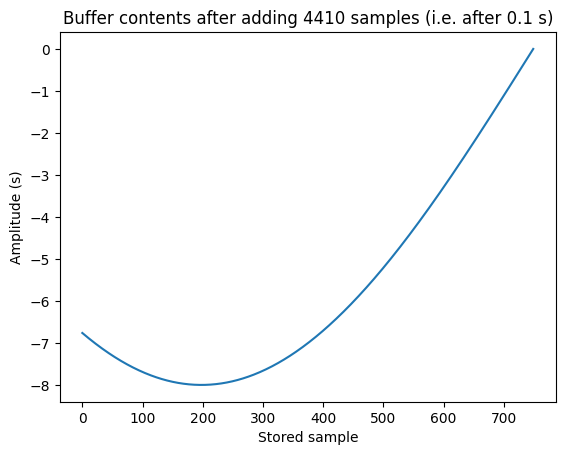

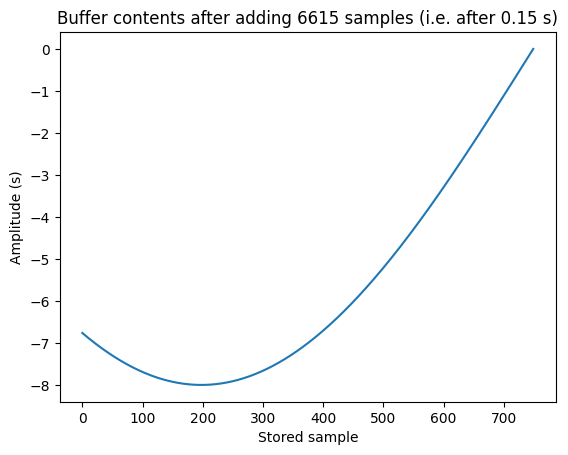

In [10]:
maxlen = 750
buffer = create_ringbuffer(maxlen)

display_at_times = [0.1, 0.15]

t, samples = create_sine_wave(f, amplitude, ws, N)
for i, samples in enumerate(samples):
    buffer.append(samples)
    for time in display_at_times:
        if i == int(time * ws):
            plot_buffer_content(buffer, i, time)
# When using our signal wave from 1.1.1, and looking at the times 0.1 & 0.01, we notice the exact same waveform.

Vérifions si cela est correcte:

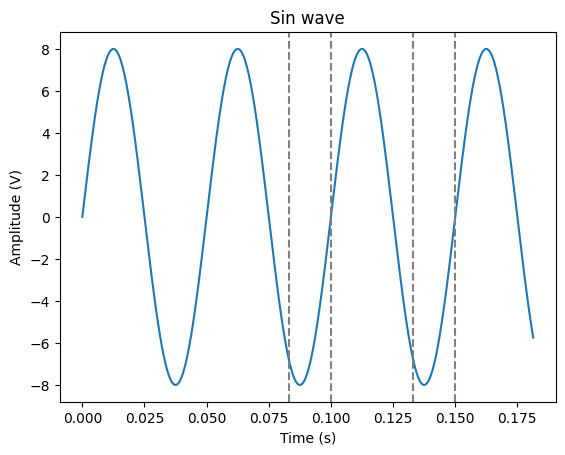

In [11]:
ws = 44.1 * 1000
N = 8000

f = 20
amplitude = 8


plot_create_sin(f, amplitude, ws, N, bars=[0.1 - (maxlen/ ws) ,0.1, 0.15 - (maxlen/ ws), 0.15])

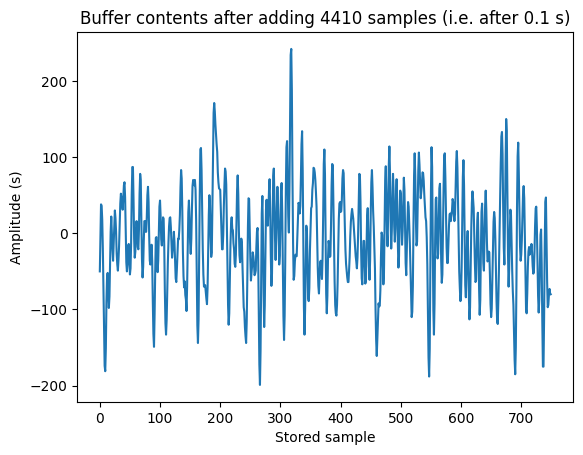

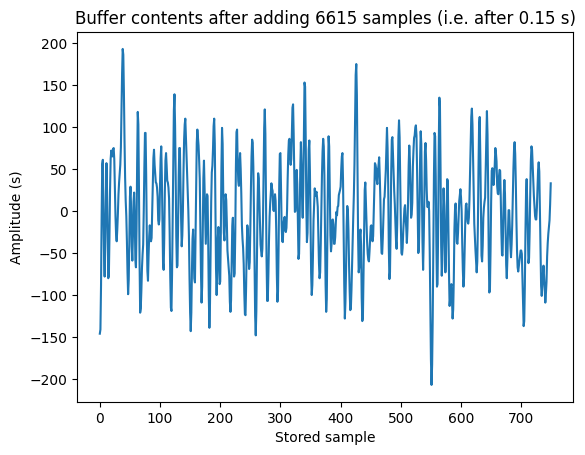

In [12]:

buffer = create_ringbuffer(maxlen)
_, data1 = read_wavefile("LocateClaps/M2_180.wav")

display_at_times = [0.1, 0.15]

for i, samples in enumerate(data1):
    buffer.append(samples)
    for time in display_at_times:
        if i == int(time * ws):
            plot_buffer_content(buffer, i, time)

## 1.3 Pre-processing

#### 1.3.1 Normalisation

In [13]:
def get_max(s):
    max = float('-inf')
    for i in s:
        if i > max:
            max = i
    return max

def normalise(s):
    max = get_max(s)
    return s / max

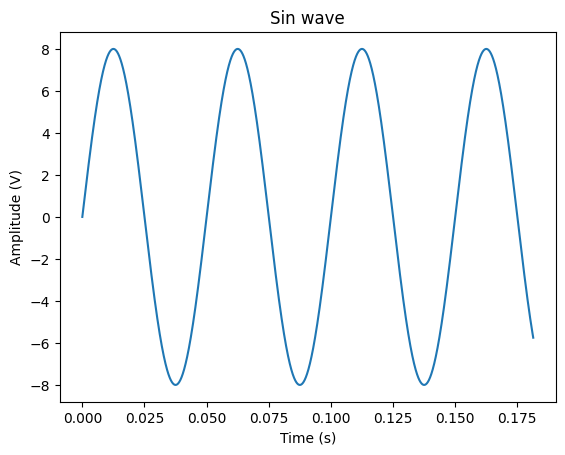

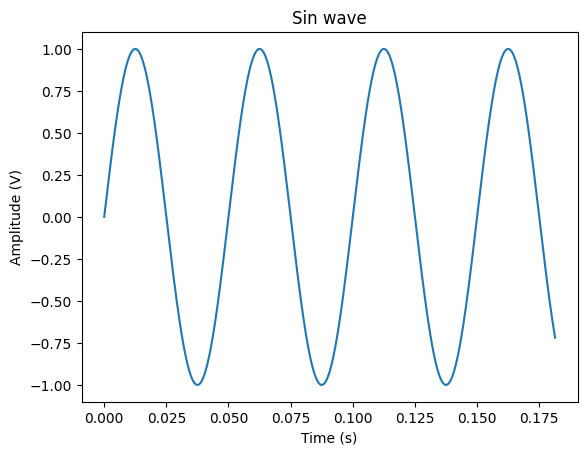

In [14]:
t, samples = create_sine_wave(f, amplitude, ws, N)

plot_sin(t, samples)
plot_sin(t, normalise(samples))


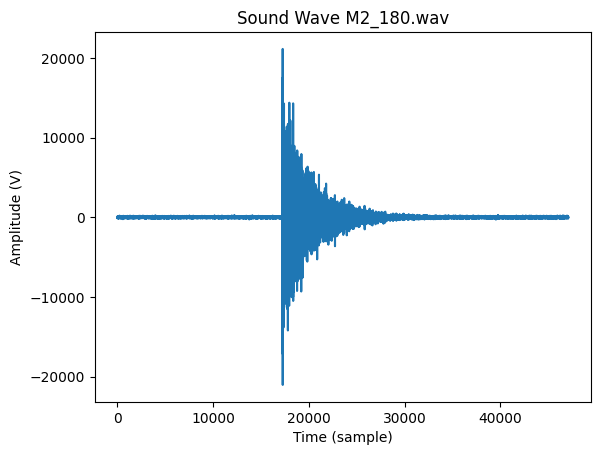

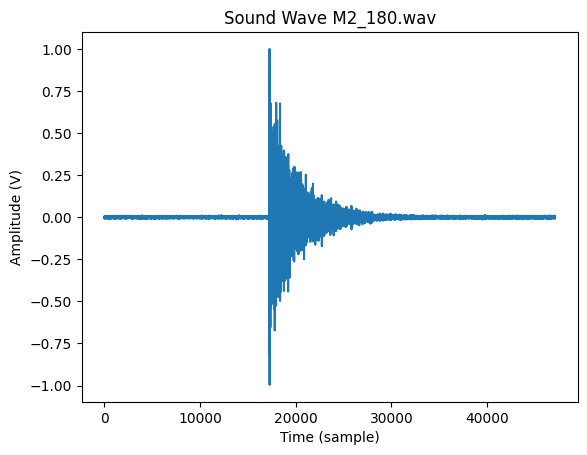

In [15]:

file_dir = "LocateClaps/"
file_name = "M2_180.wav"

_, data1 = read_wavefile(file_dir + file_name)

plot_sound_wave(data1)
plot_sound_wave(normalise(data1))


### 1.3.2 Downsampling

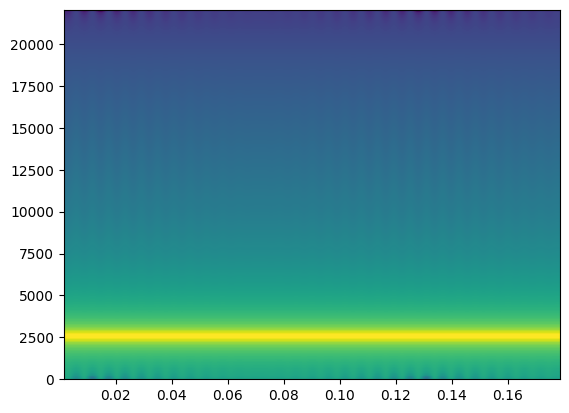

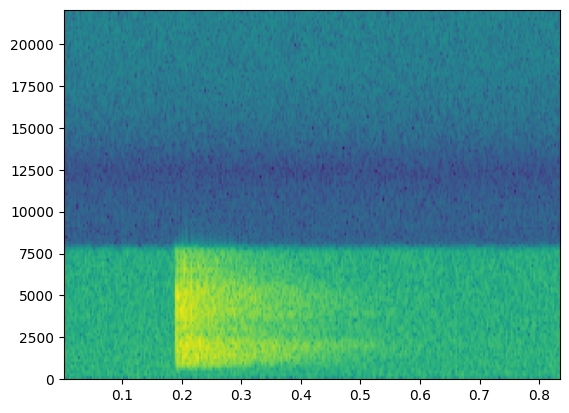

In [16]:
# Let's first take an example:
ws = 44.1 * 1000
N = 8000
f = 2500
amplitude = 8
plt.figure()
t, samples = create_sine_wave(f, amplitude, ws, N)
x = plt.specgram(normalise(samples), Fs=ws)
plt.figure()

# Using that example, let's do the same for one of the audio file :)
f, data1 = read_wavefile("LocateClaps/M1_0.wav")
x = plt.specgram(normalise(data1), Fs=f)


We notice that the maximum value is *always* 8 kHz so by **Shannon's rule** : $$f_s \geq 2 \cdot f_{max} = 2 \cdot 8000 = 16000$$ so we will take $16000$ Hz. 
This is the lowest available frequency (RAPPORT: Expliquer pourquoi on doit pas forcèment prendre plus grand (avec la computational power))

#### 1.3.2

* **`wp`** : fréquence à partir de laquelle nous souhaitons initier le blocage du signal

* **`ws`** : correspond à la fréquence où nous visons une atténuation définie par le paramètre gstop.

* **`gstop` $\equiv$ `rs`** : indique l’atténuation minimale désirée à la fréquence ws.

* **`gpass` $\equiv$ `rp`** : correspond à la perte maximale acceptable (exprimée en décibels) dans la région du filtre
définie par la fréquence wp

In [17]:
def create_filter_cheby(wp, ws, gpass, gstop, fs):
    N, wn = signal.cheb1ord(wp, ws, gpass, gstop, fs=fs)
    return signal.cheby1(N, gpass, wn, "lowpass", False, fs=fs) # lowpass because we need to filter out frequencies above a certain threshold

def create_filter_cauer(wp, ws, gpass, gstop, fs):
    N, wn = signal.ellipord(wp, ws, gpass, gstop, fs=fs)
    return signal.ellip(N, gpass, gstop, wn, 'lowpass', False, fs=fs) # TODO: Explain this line (from previous report !!!!)


Normalising does not change the value of A nor B


> (B, A) = create_filter_cheby(ws, wp,  0.3,  50 , 44100)


In [18]:
def plot_filter(B_filter, A_filter, fs):
    w_a, h_a = signal.freqz(B_filter, A_filter, fs= fs)
    plt.figure()
    plt.xlabel("f (Hz)")
    plt.ylabel("Amplitude (dB)")
    plt.plot(w_a, 20 * np.log10(np.abs(h_a)))
    plt.grid(which="both", axis="both")
    plt.show()
    plt.close()

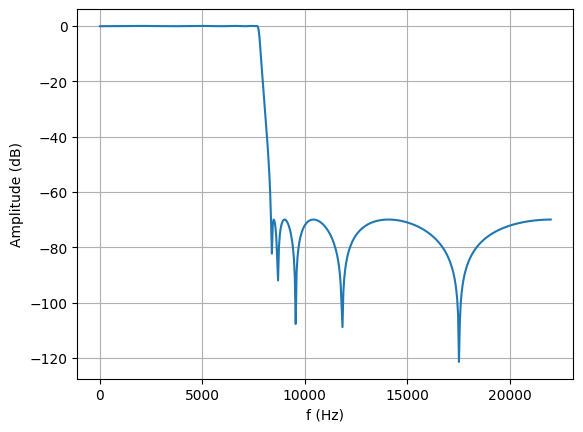

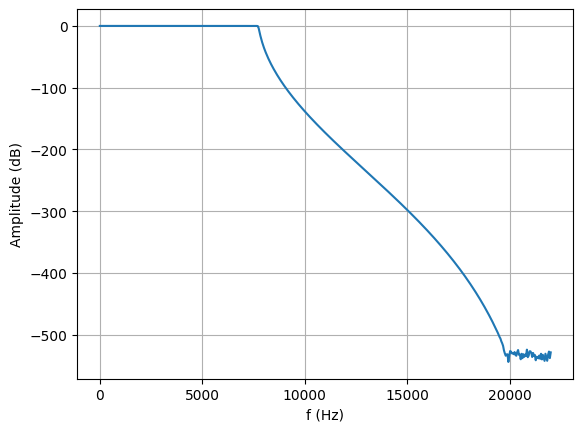

In [19]:
wp = 7700
ws = 8500
rp = 0.1
rs = 70
(B_caueur, A_caueur) = create_filter_cauer(wp, ws,  rp, rs, 44100)

(B_cheby, A_cheby) = create_filter_cheby(wp, ws,  rp,  rs, 44100)

plot_filter(B_caueur, A_caueur, 44100)

plot_filter(B_cheby, A_cheby, 44100)

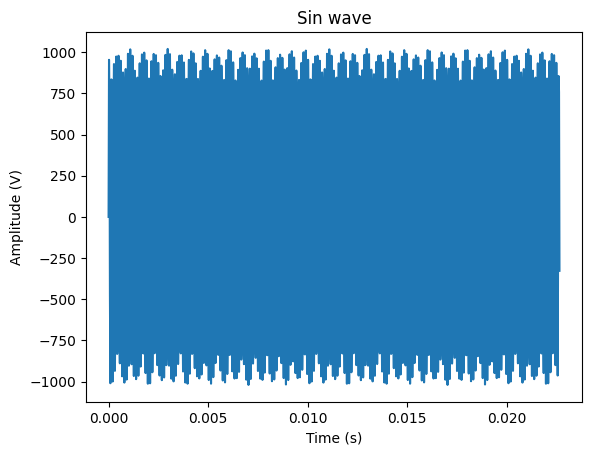

/home/axel/Desktop/gitProjects/projet_signal/env/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/axel/Desktop/gitProjects/projet_signal/env/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


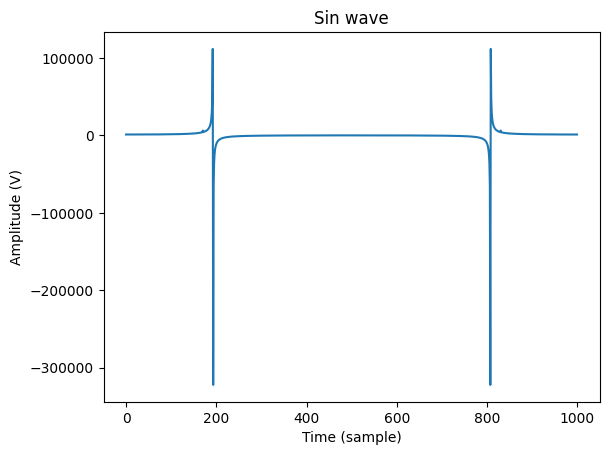

In [20]:
t, sin_samples = create_sine_wave(8500, 1000, 44100, 1000)
t, sin_samples2 = create_sine_wave(7500, 20, 44100, 1000)


sin_samples = sin_samples + sin_samples2
plot_sin(t, sin_samples)
#plot_sin(t, 20 * np.log10(np.abs(sin_samples)))

yf = np.fft.fft(sin_samples)
plot_sin(None, yf)

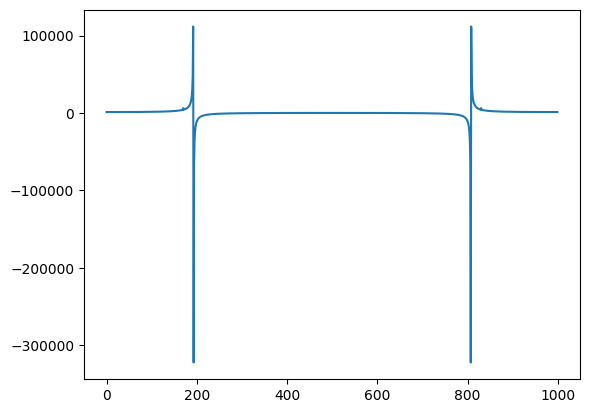

In [21]:
# Let's apply the filter to our function



output_signal = signal.filtfilt(B_caueur, A_caueur,  sin_samples)

yf = np.fft.fft(sin_samples)



simple_plot(yf, [])

#plot_sin(t, 20 * np.log10(np.abs(output_signal)))


(Normal, we don't have an infinite sinus wave)

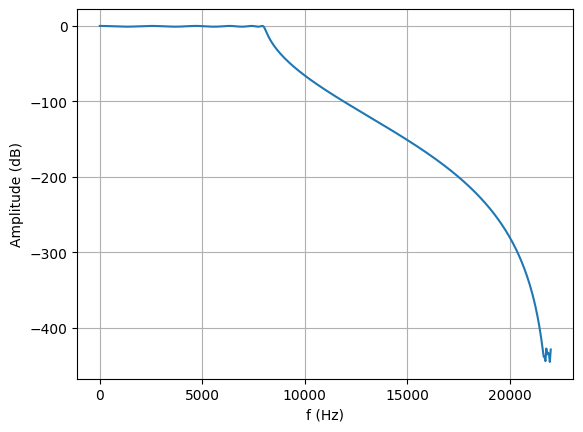

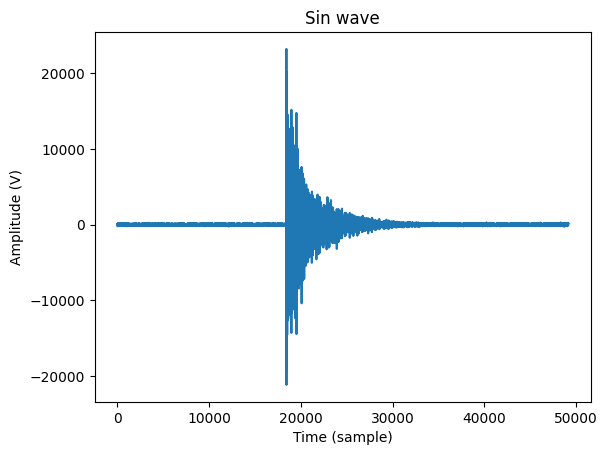

In [22]:
file_dir = "LocateClaps/"
file_name = "M1_60.wav"

_, data1 = read_wavefile(file_dir + file_name)

wp = 16000/2
ws = wp + 1000
rp = 1
rs = 40
(B_caueur, A_caueur) = create_filter_cauer(wp, ws,  rp, rs, 44100)

(B_cheby, A_cheby) = create_filter_cheby(wp, ws,  rp,  rs, 44100)

plot_filter(B_cheby, A_cheby, 44100)


# apply filter


output_signal = signal.filtfilt(B_cheby, A_cheby,  data1)



plot_sin(None,output_signal)

#### Décimation

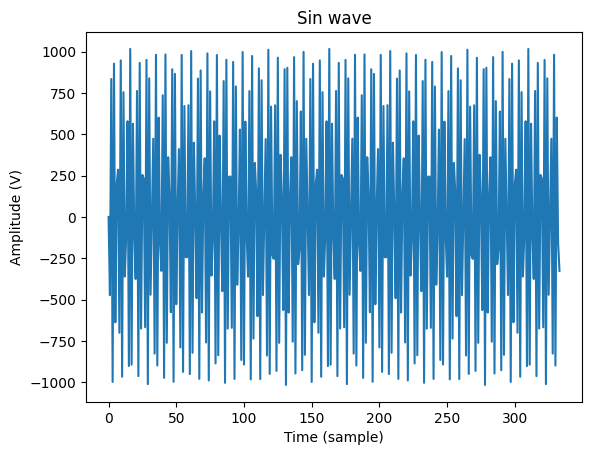

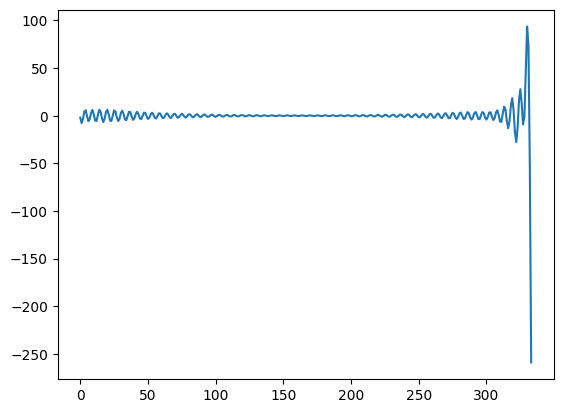

In [23]:
decimated_vec = sin_samples[::3]
plot_sin(None, decimated_vec)


output_signal = signal.filtfilt(B_caueur, A_caueur, decimated_vec)
simple_plot(output_signal)

In [24]:
def fftxcorr(in1, in2):
    
    n_1, n_2 = len(in1), len(in2)
    n = n_1 + n_2 - 1
    inv_in2 = in2[::-1]

    x = np.fft.fft(in1, n) * np.fft.fft(inv_in2, n)

    return np.fft.ifft(x, n)


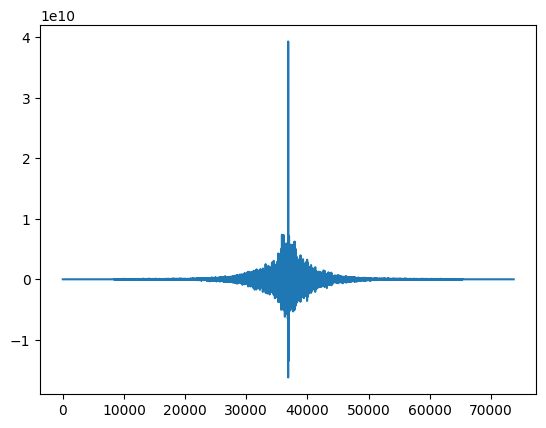

In [25]:


file_dir = "LocateClaps/"
_, data1 = read_wavefile(file_dir + "M2_0.wav")


_, data2 = read_wavefile(file_dir + "M1_0.wav")




t, sin_samples1= create_sine_wave(8500, 1000, 44100, 1000)
t, sin_samples2 = create_sine_wave(7500, 20, 44100, 1000)

y = fftxcorr(data1, data2)
simple_plot(y)



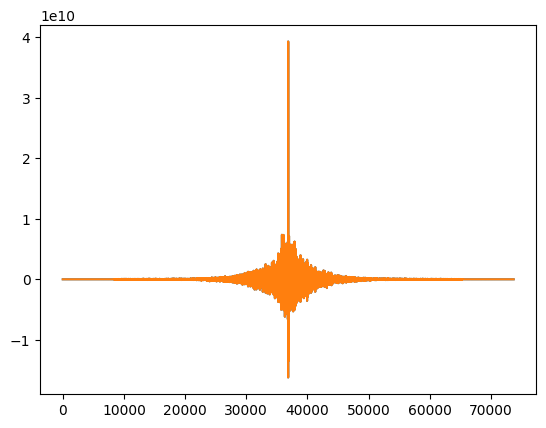

In [26]:
from scipy.signal import fftconvolve


#x = fftconvolve(data, data2, "full") # EXPLAIN IN RAPPORT
x = fftconvolve(data1, data2[::-1], "full")
plt.plot(y)
plt.plot(x)


 ! ! !!!! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !! !tdoa, ADD FS en deuxième param avec 44100 Hz par default !!!!!!!!!!!!!!!!!!!!!!!!

## TDOA

In [ ]:
def TDOA(xcorr, fs=44.1 * 1000):
    # Get the sample index with the highest value
    (i_max, sample_max) = (-float("inf"), -float("inf"))
    for (i, sample) in enumerate(xcorr):
        if sample_max < sample:
            i_max, sample_max = i, sample
    # Get the middle
    m = len(xcorr) // 2

    return (i_max - m) / fs 


file_dir = "LocateClaps/"

_, data1 = read_wavefile(file_dir + "M2_0.wav")


_, data2 = read_wavefile(file_dir + "M1_0.wav")



TDOA(y)



-0.00011337868480725624

In [67]:
from scipy.optimize import root

# mic coordinates in meters

MICS = [{'x': 0, 'y': 0.0487}, {'x': 0.0425, 'y': -0.025}, {'x': -0.0425, 'y': -0.025}] 

def equations(p, deltas):
    v = 343
    x, y = p
    alpha = np.arctan2((MICS[1]['y'] - MICS[0]['y']), (MICS[1]['x'] - MICS[0]['x']))
    beta = np.arctan2((MICS[2]['y'] - MICS[0]['y']), (MICS[2]['x'] - MICS[0]['x']))
    
    eq1 = v*deltas[0] - (np.sqrt((MICS[1]['x'] - MICS[0]['x'])**2 + (MICS[1]['y'] - MICS[0]['y'])**2) * np.sqrt((x)**2 + (y)**2) * np.cos(alpha-np.arctan2(y, x)))
    eq2 = v*deltas[1] - (np.sqrt((MICS[2]['x'] - MICS[0]['x'])**2 + (MICS[2]['y'] - MICS[0]['y'])**2) * np.sqrt((x)**2 + (y)**2) * np.cos(beta-np.arctan2(y, x)))
    return (eq1, eq2)
    
def localize_sound(deltas):
    sol = root(equations, [0, 0], (deltas), tol=10)
    return sol.x

def source_angle(coordinates):
    XS, YS = coordinates
    out = np.arctan2(YS, XS)* 180/np.pi
    # print("=> ",coordinates, " | o: ", out )
    if out < 0:
        out += 360
    return out 


In [68]:

file_dir = "LocateClaps/"
file_extension = ".wav"
real_angles = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]


for real_angle in real_angles:
    data1 = read_wavefile(file_dir + "M1_" + str(real_angle) + file_extension)[1]
    data2 = read_wavefile(file_dir + "M2_" + str(real_angle) + file_extension)[1]
    data3 = read_wavefile(file_dir + "M3_" + str(real_angle) + file_extension)[1]


    
    d1 = TDOA(fftconvolve(data1, data2[::-1], "full"))
    d2 = TDOA(fftconvolve(data1, data3[::-1], "full"))
    #print(f"=== D1: {d1}  | D2: {d2}")
    S = localize_sound([d1, d2])
    print(f"Real angle: ({real_angle}) | Computed angle: ({source_angle(S)})")

Real angle: (0) | Computed angle: (0.0)
Real angle: (30) | Computed angle: (29.970421179794062)
Real angle: (60) | Computed angle: (59.97040343760042)
Real angle: (90) | Computed angle: (84.17557978606705)
Real angle: (120) | Computed angle: (120.02959656239959)
Real angle: (150) | Computed angle: (150.02957882020596)
Real angle: (180) | Computed angle: (180.0)
Real angle: (210) | Computed angle: (209.97042117979407)
Real angle: (240) | Computed angle: (239.9704034376004)
Real angle: (270) | Computed angle: (270.0)
Real angle: (300) | Computed angle: (300.0295965623996)
Real angle: (330) | Computed angle: (324.214893078145)


In [ ]:
possible_angle = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
for angle in possible_angle:
    for f in files:
        if f'_{angle}.' in f:
            mic = f.split('/')[-1].split('_')[0] #if '/' does not work, use "\\" (windows notation)